# BlueCloud Zooplankton Demonstrator

This notebook plots the results from the previous notebook DIVAndNN_analysis.ipynb.

In [25]:
using DIVAnd
using DIVAndNN
push!(LOAD_PATH,@__DIR__)
using BlueCloudPlankton
using Dates
using JSON
using PyPlot
using Glob
using Statistics
using NCDatasets

In [26]:

include("grid.jl")
datafile = joinpath(datadir, "data-cpr.csv")

"../data/data-cpr.csv"

Bathymetry for plotting

In [27]:
bathname = joinpath(datadir,"gebco_30sec_4.nc");
bathisglobal = true;
bx,by,b = DIVAnd.extract_bath(bathname,bathisglobal,gridlon,gridlat);

Load observations and analysis

In [33]:
expdir = joinpath(resdir,"results-ncovars3-epsilon2ap10-len300000.0-niter500-nlayers3-ndimensions2")
lon, lat, dates, value, scientificNames = BlueCloudPlankton.read_data(datafile)
scientificname_accepted = unique(scientificNames)

6-element Array{Any,1}:
 "Metridia lucens"
 "Calanus finmarchicus"
 "Oithona"
 "Temora longicornis"
 "Acartia"
 "Calanus helgolandicus"

Helper functions for plotting

In [29]:
function decorate()
    colorbar(orientation="horizontal")
    contourf(bx,by,b' .> 0, levels=[0,.5], cmap = "gray")
    gca().set_aspect(1/cosd(mean(gridlat)))
end

decorate (generic function with 1 method)

In [30]:
function plotfield(filename)
    fig = figure(figsize = (10,5))
    sname = split(basename(filename),"_")[2]

    ds = Dataset(filename)
    value_analysis = nomissing(ds[sname * "_L1"][:,:],NaN)
    gridlon = ds["lon"][:]
    gridlat = ds["lat"][:]
    close(ds)

    sel = scientificNames .== sname
    XY = DIVAnd.ndgrid(gridlon,gridlat)
    value_binned = DIVAndNN.binobs((lon[sel],lat[sel]),value[sel],XY);

    cl = quantile(value_binned[isfinite.(value_binned)],[0.01, 0.99])
    if cl[1] == 0
        cl = (cl[2]/100,cl[2])
        @warn "setting explicitly lower scale to $(cl[1]) for $sname"
    end

    norm = PyPlot.matplotlib.colors.LogNorm(vmin=cl[1], vmax=cl[2])

    clf()
    fig.suptitle(sname,style="italic")
    subplot(1,2,1)
    pcolormesh(gridlon,gridlat,value_binned', norm = norm)
    title("Binned observations")
    decorate()


    subplot(1,2,2)
    pcolormesh(gridlon,gridlat,value_analysis', norm = norm)
    title("Analysis")
    decorate()
    savefig(joinpath(figdir,"$sname.png"))
end

plotfield (generic function with 1 method)

Plot the result for the first species

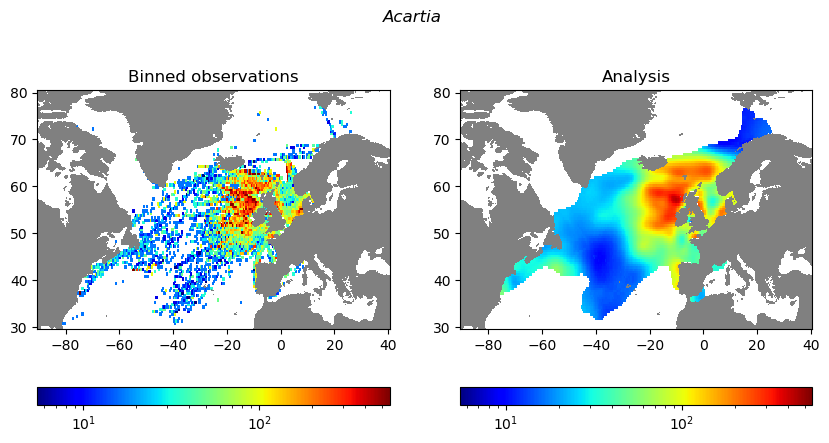

┌ Warning: setting explicitly lower scale to 5.501630952380976 for Acartia
└ @ Main In[30]:18


In [34]:
filenames = glob("*nc",expdir);
plotfield(filenames[1]);

Plot the all species

┌ Warning: setting explicitly lower scale to 5.501630952380976 for Acartia
└ @ Main In[30]:18
┌ Warning: setting explicitly lower scale to 1.4999999999999982 for Oithona
└ @ Main In[30]:18


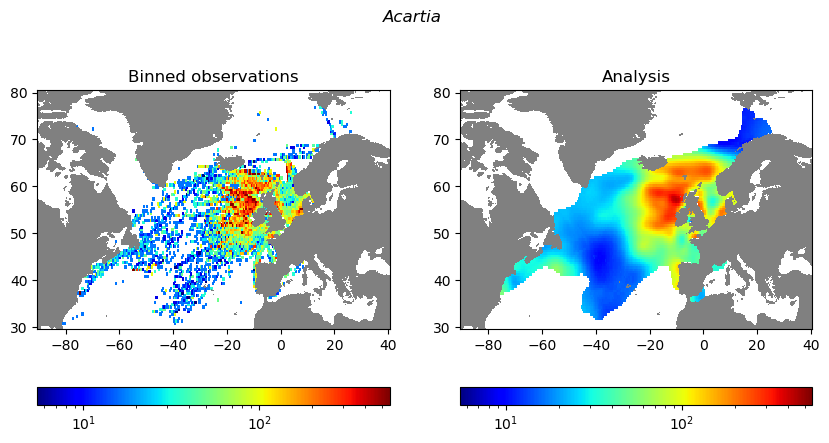

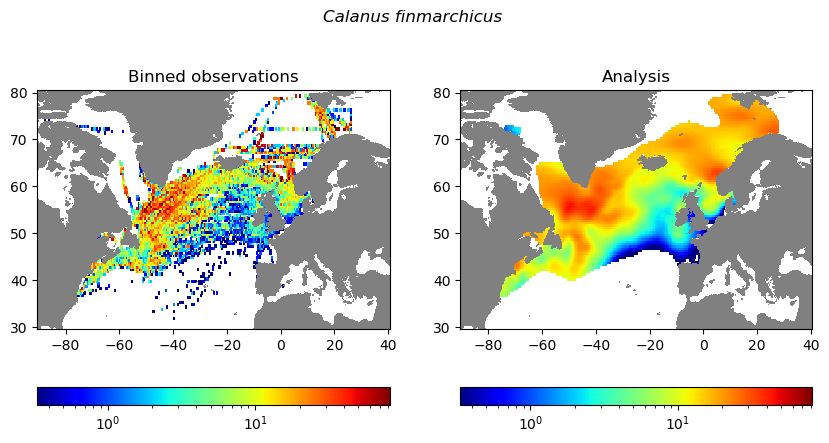

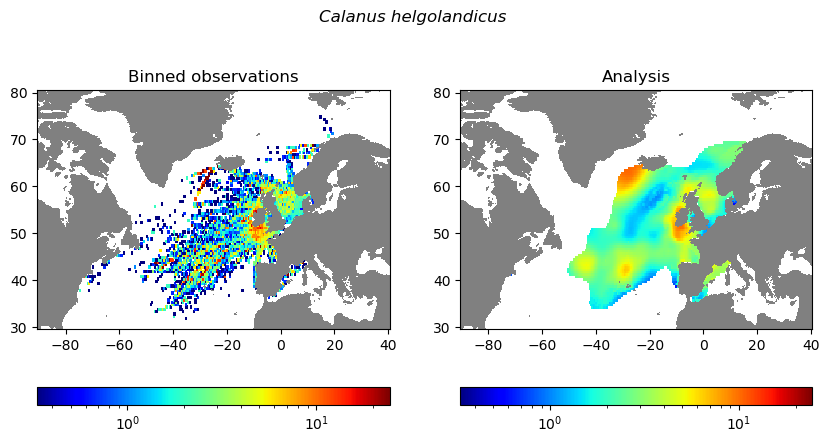

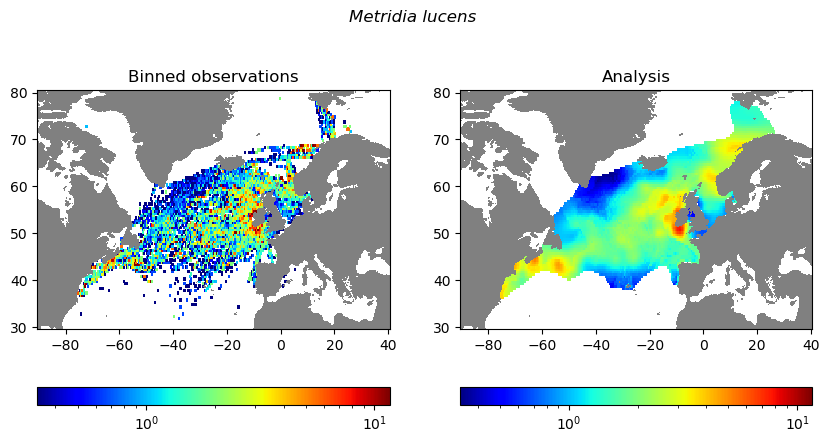

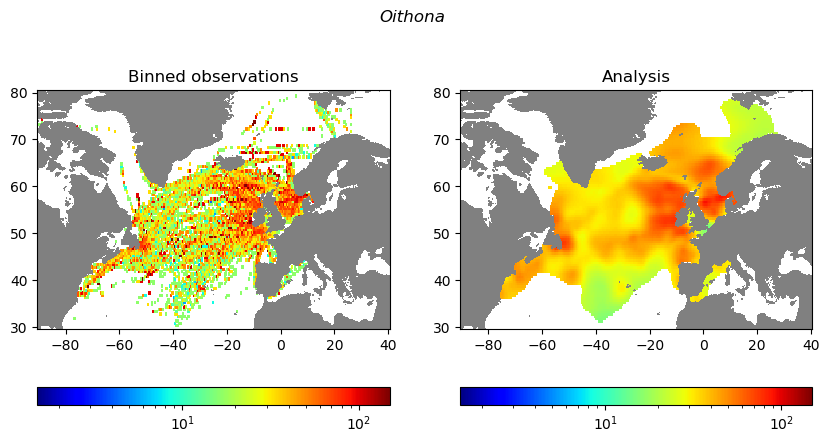

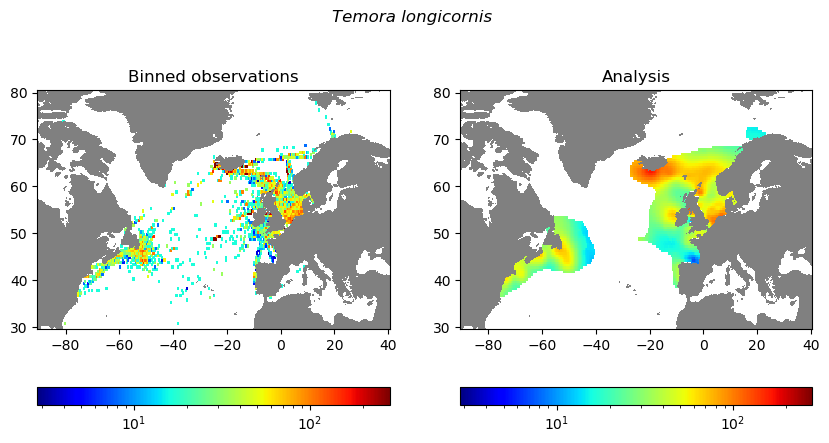

┌ Warning: setting explicitly lower scale to 2.83333333333333 for Temora longicornis
└ @ Main In[30]:18


In [35]:
plotfield.(filenames);